#  Global Annual Temperature Anomalies (degrees C) 1850-2015

_Parece que los notebooks no están muy perfecionados (o mi instalación tiene problemas). Algunos comandos fallan la primera vez que se ejecutan._

Para el filtrado (filtro de Kalman y suavizado de intervalo fijo) usaremos la toolbok [E4](https://www.ucm.es/e-4/), para ello es necesario ejecutar lo siguiente:

In [90]:
clear
e4init


            XXXXXX 4 4      XXXXX  XX     XX  XX  XXXXXX (c)
           XX      444     XX  XX XX     XX  XX  XX
          XXXX       4    XXXXX  XX     XX  XX  XXXXXX
         XX              XX     XX     XX  XX      XX
        XXXXXX          XX     XXXXXX XXXXXX  XXXXXX

    Toolbox for State Space Estimation of Econometric Models
 
*********************** Options set by user ********************
Filter. . . . . . . . . . . . . : KALMAN
Scaled B and M matrices . . . . : NO
Initial state vector. . . . . . : AUTOMATIC SELECTION
Initial covariance of state v.  : IDEJONG
Variance or Cholesky factor?  . : VARIANCE
Optimization algorithm. . . . . : BFGS
Maximum step length . . . . . . : 0.100000
Stop tolerance. . . . . . . . . : 0.000010
Max. number of iterations . . . :       75
Verbose iterations. . . . . . . : YES
****************************************************************
 
 


Tambien es necesario cargar el toolbox de control

In [91]:
pkg load control

Cargamos los datos `gta.data` correspondientes a [Global and Hemispheric Temperature Anomalies - Land and Marine Instrumental Records](https://cdiac.ess-dive.lbl.gov/trends/temp/jonescru/jones.html) 

In [92]:
load gta.data

La decimocuarta columna de la matriz `gta` contiene los datos anuales correspondientes a los años 1850--2015. Por comodidad generamos la variable `y` con dichos datos anuales (es decir `p=1`).

In [93]:
y = gta(:,14);
p = 1;

y ahora vamos a representar los datos de la serie

In [94]:
%plot gnuplot
title('Global Annual Temperature Anomalies')
plot(y, 'r')

... pero mejor si las figuras se insertan en el propio notebook en formaton `png`...

In [95]:
%plot --format png

y aún mejor si usamos las fechas en el eje horizontal

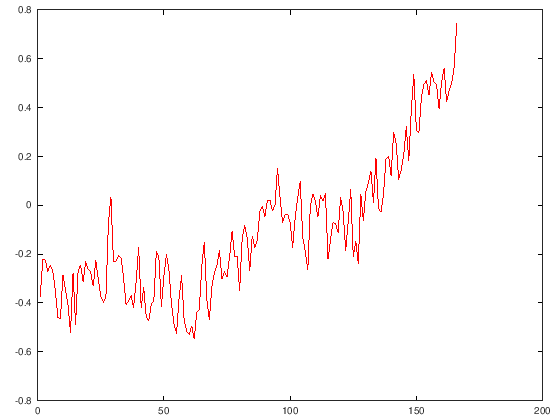

In [96]:
dates = gta(:,1);

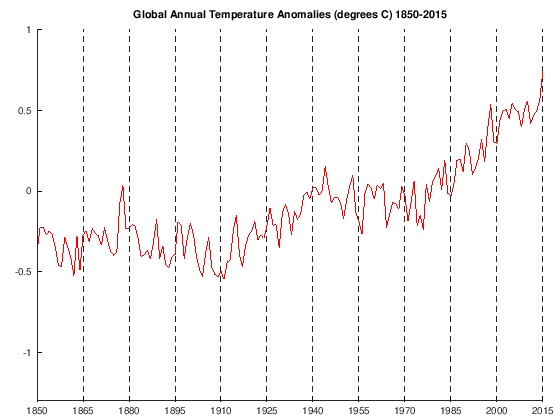

In [97]:
yr = datenum (dates,1,1);
plot(yr, y, 'r')
set (gca(), "xtick", datenum (1850:15:2020,1,1));
datetick ("x", "YYYY", "keepticks");
set (gca(), "xgrid", "on");
set(gca,'GridLineStyle','--')
hold on
ylim([-1.3, 1])
title('Global Annual Temperature Anomalies (degrees C) 1850-2015')
box off;

Voy a definir un rango de órdenes AR. Puesto que vamos a trabajar con datos anuales, es mejor usar órdenes autorregresivos largos para evitar identificar tendencias ruidosas.

In [98]:
rgar = [50:80];

Si no indicamos un modelo a priori y la periodicidad de los datos es anual `(p=1)`, la toolbox `LDHR` intenta ajustar un modelo de tendencia IRW (_si ello es posible_) más ruido.

In [99]:
#[VAR,P,TVP,oar,results,MCNN,NVR]=autodhr(y,1,[],rgar);
[VAR,P,TVP,oar]=autodhr(y,p,[],rgar)

VAR =

   4.6580e-03   2.1466e-06

P = Inf
TVP =

   1
   1

oar = 63


Usando este modelo, filtramos (_Fixed-interval smoothing_) la serie para obtener los componentes

In [100]:
[Trend,season,cycle,irreg]=dhrfilt(y,P,TVP,VAR,12,0,0);

Vamos a dibujarlos

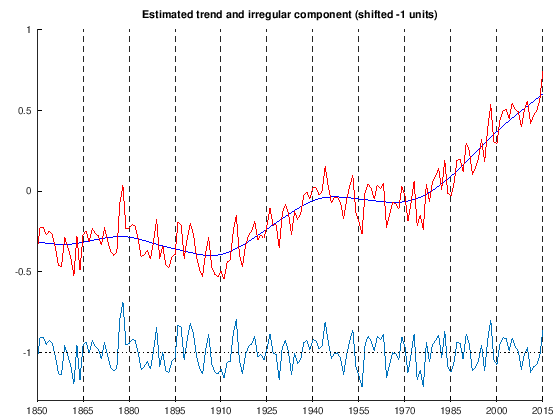

In [101]:
plot(yr, Trend, '-b')
set (gca(), "xtick", datenum (1850:15:2015,1,1));
datetick ("x", "YYYY", "keepticks");
set (gca(), "xgrid", "on");
set(gca,'GridLineStyle','--')
hold on
plot(yr, y,'-r')
plot(yr, irreg-1)
plot(yr, -ones(length(y)), ':k')
ylim([-1.3, 1])
title('Estimated trend and irregular component (shifted -1 units)')
box off;

La tendencia muestra un comportamiento cíclico. Si ajustamos un polinomio AR (por ejemplo, del mismo ordén que el elegido por `autodhr`) y miramos la periodicidad asociada las raíces de mayor módulo, nos encontramos con un ciclo de aproximadamente 63 años, y además, parce que también hay picos espectrales en sus armónicos enteros: $63/3=21$ y $63/9=9$ (he probado con otros armónicos no enteros... pero `autodhr` no logra identificar componentes `DHR` para dichos armónicos... esto me hace pensar que quizá el rítmico impulso anual hace que el sistema entre en resonancia justo en las frecuencias correspondientes a años completos... si no fuera así, querría decir que hay componentes armónicos tales que aumentan de temperatura a veces en verano, y a veces en invierno, lo que iría en contra de la intuición). 

In [102]:
[ARSPT, S, LAGS, AR, ROOTS, NORM, P] = aresp(Trend,oar);
[s,i]=sort(NORM,'descend');
[P,NORM](i(1:16),:)
63./[1:7]

ans =

       Inf    1.0379
    2.5014    1.0086
   63.6238    0.9999
    2.0000    0.9966
    4.1143    0.9945
    2.8822    0.9930
    3.5702    0.9917
    5.2172    0.9913
    7.6056    0.9912
    2.0509    0.9911
    2.1477    0.9899
   20.6464    0.9897
    2.2356    0.9877
    8.9746    0.9875
   14.8026    0.9855
    4.7472    0.9845

ans =

   63.0000   31.5000   21.0000   15.7500   12.6000   10.5000    9.0000



Por tanto, vamos a intentar ajustar un modelo con tendencia, ciclo de 63 años y dos armónicos (de 21 y 9 años), y un componente irregular

In [103]:
#[VAR,P,TVP,oar,results,MCNN,NVR]=autodhr(y,1,[],rgar,[inf,63,21,9],[1, 1 ; 1, 0],0)
[VAR,P,TVP,oar]=autodhr(y,1,[],rgar,[inf,63,21,9])

VAR =

   7.1777e-03   3.6967e-06   1.3487e-04   3.2839e-06   1.6465e-05

P =

   Inf    63    21     9

TVP =

   1   1   1   1
   1   0   0   0

oar = 54


¡Parece que ha funcionado! Estimemos los componentes:

In [104]:
[Trend,season,cycle,irreg]=dhrfilt(y,P,TVP,VAR,12,0,0);

`Trend` es una matriz con tres columnas, la primera es la _Tendencia-Ciclo_, compuesta por la _Tendencia a largo plazo_ (segunda columna) más un _Ciclo_ formado por oscilaciones de periodos 63, 21 y 9 (tercera columna). Veámos dichos componentes:

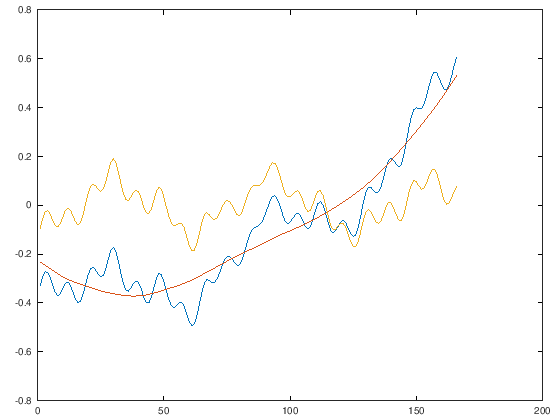

In [105]:
plot(Trend)

Como se puede ver, la _Tendencia-Ciclo_ ajusta bastante bien la evolución de la serie [Global and Hemispheric Temperature Anomalies - Land and Marine Instrumental Records](https://cdiac.ess-dive.lbl.gov/trends/temp/jonescru/jones.html) 

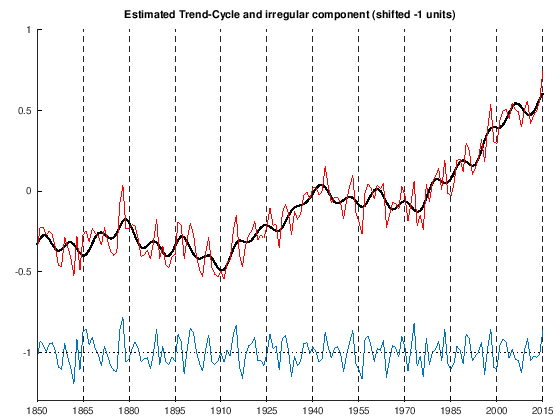

In [106]:
plot(yr, Trend(:,1), '-k', "linewidth", 4)
set (gca(), "xtick", datenum (1850:15:2015,1,1));
datetick ("x", "YYYY", "keepticks");
set (gca(), "xgrid", "on");
set(gca,'GridLineStyle','--')
hold on
plot(yr, y,'-r')
plot(yr, irreg-1)
plot(yr, -ones(length(y)), ':k')
ylim([-1.3, 1])
title('Estimated Trend-Cycle and irregular component (shifted -1 units)')
box off;

Pero más ilustrativo es pintar la _Tendencia_ a largo plazo por una parte, y el _Ciclo_ por otra, pues parece que el ciclo replica el comportamiento de la serie [Atlantic Multidecadal Oscillation (AMO)](https://www.psl.noaa.gov/data/timeseries/AMO/)

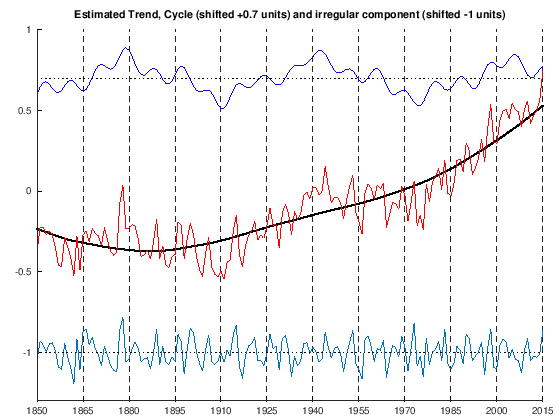

In [107]:
plot(yr, Trend(:,2), '-k', "linewidth", 4)
set (gca(), "xtick", datenum (1850:15:2015,1,1));
datetick ("x", "YYYY", "keepticks");
set (gca(), "xgrid", "on");
set(gca,'GridLineStyle','--')
hold on
plot(yr, y,'-r')
plot(yr, irreg-1)
plot(yr, -ones(length(y)), ':k')
plot(yr, Trend(:,3)+0.7, '-b')
plot(yr, ones(length(y))*.7, ':k')
ylim([-1.3, 1])
title('Estimated Trend, Cycle (shifted +0.7 units) and irregular component (shifted -1 units)')
box off;